# Course Project No 3 - Part 2 - House prices

Let's import all the base libraries that we will use in this Notebook

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Insight:
# Pour les missing values, créer une catégorie missing
# Ne pas supprimer les colonnes en première instance, à faire plus tard dans la construction de modèles simples.
# Utiliser les histogrammes simples pour évaluer les outliers des colonnes numériques.
# Pour les colonnes avec données manquantes, une LinearRegression sera pénalisée alors que les regression type Ridge seront moins sensibles
# Le drop de colonne pourra être évalué avec une approche Grid en jouant sur l'alpha du Ridge (si pas d'influence, on ne doit pas trouver d'outfitting
# en diminuant la valeur de l'alpha)

# !!! Ordinal values: À classer


## Goal of this second part

Estimate the price of 500 houses using a model based on 2'430 house prices, analyzing a dataset made of 82 features

## Load the datasets

So we have two files, one for the train dataset, the other for the test.

As we will have to duplicate, transform, maybe drop columns in both dataset, I've decided to concat both into one big dataset, and define a utility functions that returns test and train values as separated dataframes.

### Train Dataset

In [2]:
train_df = pd.read_csv(os.path.join('data','house-prices.csv'))
print("Size of the train dataset:", train_df.shape)
train_df.head(3)

Size of the train dataset: (2430, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000


### Test Dataset

In [3]:
test_df = pd.read_csv(os.path.join('data','house-prices-test.csv'))
print("Size of the test dataset:", test_df.shape)
test_df.head(3)

Size of the test dataset: (500, 81)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,2217,909279080,50,RL,NaN,11275,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1,837,907126050,20,RL,65.0,9757,Pave,NaN,Reg,Low,...,92,0,NaN,NaN,NaN,0,10,2009,WD,Normal
2,2397,528144030,60,RL,86.0,11065,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,10,2006,New,Partial


### Merge datasets into one dataframe

The merged dataset will be stored in a variable named *data_df*

> Note: Test dataset is missing the 'SalePrice' column. We must add an empty column to it before concatenating it with train dataset

In [4]:
# Define target column name as a variable
target_column='SalePrice'

# Add empty 'SalePrice' columnto Test dataset
test_df[target_column] = np.nan

# Concat both dataframe
data_df = pd.concat([train_df, test_df])

# Verify size of resulting dataframe
print("Size of global dataframe. Must be (2930,82):\t", data_df.shape)

# Define function that split back dataframes
def getTrainDataset():
    global data_df
    global target_column
    
    return data_df[np.logical_not(data_df[target_column].isnull())]

# Define function that split back dataframes
def getTestDataset():
    global data_df
    global target_column
    
    return data_df[data_df[target_column].isnull()]

# Verify size of trainig dataframe
print("Size of global dataframe. Must be (2430,82):\t", getTrainDataset().shape)

# Verify size of resulting dataframe
print("Size of global dataframe. Must be (500,82):\t", getTestDataset().shape)




Size of global dataframe. Must be (2930,82):	 (2930, 82)
Size of global dataframe. Must be (2430,82):	 (2430, 82)
Size of global dataframe. Must be (500,82):	 (500, 82)


## Utility functions

Before working on our dataset, let's define some utility functions that will be used in our Notebook.
This will simplify our code.

### Drop and One-encode

Along the Notebook, we will have to drop columns and one-encode others.

Instead of dropping column immediately, we had the columns to drop in a *column_to_drop* set to be removed later. This trick allows us to run cell notebook several time without side effect. Of course, as soon as the drop command is applied on this set, the previous cells might not work and the notebook should be rerun from beginning.

Same for one-hot encoding, we define a *columns_to_encode* set() to perform the one-hot encoding later.

We create two functions to manipulate those two variables and a third one to execute the job, taking care of the global variables

> Note 1: One-hot encoding must be done prior to the drop call as some of the flagged columns to be dropped are created by the 'one-hot' encoding process.

> Note 2: Reset the two variables *columns_to_drop* and *columns_to_encode* afterward in case we reuse them


In [5]:
# Store the columns to be dropped
columns_to_drop = set()

# Store the columns to be ont-hot encoded
columns_to_encode = set()

# Function to add columns to be dropped
def addColumnToDropList(columns = []):
    """
    Adds columns received as parametr to columns_to_drop global var
    """
    global columns_to_drop
    for c in columns:
        columns_to_drop.add(c)
    print("Columns flaged as 'to be removed':", ",".join(columns_to_drop))

# Function to add columns to be one-hot encoded
def addColumnToOneHotEncoding(columns = []):
    """
    Adds columns received as parametr to columns_to_encode global var
    """
    global columns_to_encode
    for c in columns:
        columns_to_encode.add(c)
    print("Columns flaged as 'to be one-hot encoded':", ",".join(columns_to_encode))
    
def dropAndEncode():
    global columns_to_drop
    global columns_to_encode
    global data_df
    """
    This function handle drop and one-hot encoding on the data_df dataset
    """
    print("Size of the dataframe BEFORE applying one-hot encoding:", data_df.shape)
    if (len(columns_to_encode) > 0):
        print("  Do 'one-hot' encoding on:", columns_to_encode)
        data_df = pd.get_dummies(data_df, columns=columns_to_encode)
    print("Size of the dataframe AFTER applying one-hot encoding:", data_df.shape)
    if (len(columns_to_drop) > 0):
        print("  Drop columns:", columns_to_drop)
        data_df.drop(columns_to_drop, axis=1, inplace=True)
    print("Size of the dataframe AFTER dropping column and applying one-hot encoding:", data_df.shape)

    # reset global var as the job has been done
    columns_to_drop = set()
    columns_to_encode = set()  


### Where Clause Replacement

On columns from which we could extract binary information (for example, does the house has a pool or not?), instead of doing a one-hot encoding exercice after replacing values, we can define a function using the *np.where()* method to globaly modified the column values in one shot.

In [6]:
def whereClauseReplacement(column, condition, suffix=' Exists', true_value=0, false_value=1, drop_original_column = True):
    """
    Function take a np.array of boolean and a column name to apply an np.where call on it.
    true_value and false_value default to 1 and 0
    The resulting value is added in a new column using the column name parameter and a suffix parameter.
    A drop_original_column can be provided to decide if the orignal column should be dropped. It is set by default to True
    """
    
    global data_df
    
    print("Doing a binary replacement on column", column)
    new_column = column + suffix
    print("  New column name:", new_column)
    data_df[new_column] =np.where(condition, true_value, false_value)
    if (drop_original_column == True):
        print("  Drop original column")
        addColumnToDropList([column])
    # ensure new column contains at least and no more 2 values
    if (len(data_df[new_column].unique()) != 2):
        raise SystemExit("WARNING: whereClauseReplacement found number of values != 2. Aborting Notebook execution")


### Transform literal ordinal column to numerical one

Most of the ordinal columns, according to documentation, values in those columns are categories written as strings. The following utility function is used to convert literal values by numeric ones. The mapping between literal and numeric values is passed to the function as a dictionnary.


In [7]:
# Function definition to rencode ordinal column to numerical 
def encodeLiteralToNumericValues(column, mapping={}, replacena= None):
    """
    This function replaces values in column passed as parameter using the mapping dict provided.
    Key of the dict are used as search value in cells, and if match, cell value is replace by the value
    of mapping[key]
    replacena parameter, if different from None is used as replacement of null values
    Note that dtype of modified column is automatically set to int64 if all values have been replaced with numeric one
    Function also prints the unique values found in the column after transformation. This information could be used
    to validate that we've not missed any replacement.
    We do also ensure that column received as parameter does not contains only a numeric values. if it is the cas, then
    the function simply returns.
    """
    global data_df
    
    print("Encoding column {} to numerical values".format(column))
    # Does the column contains only numeric
    if pd.api.types.is_numeric_dtype(data_df[column].dtype):
        # yes, return
        print("  Column is already numerical. Nothing to do.")
        return

    # replace values using mapping
    data_df[column] = data_df[column].map(mapping)
    # replace null values
    if replacena != None:
        data_df[column] = data_df[column].fillna(replacena)

        
    # Do an exit(1) if resulting column is not a numeric one
    if pd.api.types.is_numeric_dtype(data_df[column].dtype) == False:
        raise SystemExit("WARNING: encodeOrdinalColumnToNumeric returns a non numerical column. Aborting Notebook execution")
    else:
        print("  Column successfully encoded with numerical values")
    print("  Values in column:", data_df[column].unique())

    return



## Data cleaning

Data in this set is not optimal and has to be cleaned before being used. Here is the methodology followed.


### Drop useless columns

Order and PID columns are useless to fit models. Drop it :-)


In [8]:
addColumnToDropList(['Order','PID'])

Columns flaged as 'to be removed': Order,PID


### Handle columns with more than 20% empty cells
Some of the columns contains a huge amount of null cells, we should drop them as they won't be pertinent if we were seeking for data quality.
But, in Machine Learning approach, it's a better choice to keep all the data available, modifying it a little bit to suit model fitting process.
Why seeking for 20% of empty cells in columns ? No specific reason, arbitrary choice :-)

Let's identify those columns.

In [9]:
# Number of lines in dataset
total_line = data_df.shape[0]

# NULL_CELL_LIMIT is the max allowed percentage of null value in a column
NULL_CELL_LIMIT = 0.20

# List of columns that we will drop
identified_column = list()

# Loop in each column and identify the one to drop
for c in data_df.columns:
    no_of_null_cell = data_df[c].isnull().sum()
    if(no_of_null_cell/total_line > NULL_CELL_LIMIT):
        identified_column.append(c)

print("Columns with mode than 20% of empty cells:", ','.join(identified_column))

data_df[identified_column].isnull().sum().sort_values(ascending=False)

Columns with mode than 20% of empty cells: Alley,Fireplace Qu,Pool QC,Fence,Misc Feature


Pool QC         2917
Misc Feature    2824
Alley           2732
Fence           2358
Fireplace Qu    1422
dtype: int64

So, we've found 5 columns. Here is what I've decided to do with them.

#### Pool QC: 

On the whole dataset, we found that only 12 houses are equiped with a pool.
Choice is made to do a one-hot encoding on the 'Pool QC' column to simply identify houses with a pool, by replacing null values by 0, others by 1.

To simplify coding, we define here a function that performs the 'where' binary replacement on a list of dataset, which defaults to our previously initialized variable: dataframe_list


In [10]:
# Ensure that number of houses without a pool is in line with the poll size information (only houses with
# a pool should have a pool area above 0)
print("Number of houses with pool:\t",data_df.shape[0] - data_df['Pool QC'].isnull().sum())
print("Number of pool area > 0:\t",data_df[data_df['Pool Area'] > 0]['Pool Area'].count())

whereClauseReplacement('Pool QC', data_df['Pool QC'].isnull())

Number of houses with pool:	 13
Number of pool area > 0:	 13
Doing a binary replacement on column Pool QC
  New column name: Pool QC Exists
  Drop original column
Columns flaged as 'to be removed': Order,PID,Pool QC


#### Alley
NaN means house without alley. We should split the 'Alley' information into two different one: Does the house has an alley, and what type is the alley.
Do a hot encoding on alley to get the 'Alley Type' for each house, and another one-hot encoding on 'Alley' to get the 'Alley Exists' column. For the alley_exists one hot encoding, we use our previous defined function binaryNullWhereClauseReplacement()


In [11]:
# Duplicate 'Alley' column to 'Alley Type' in all dataframe
data_df['Alley Type'] = data_df['Alley']

# Do a one hot encoding on 'Allay Type'
addColumnToOneHotEncoding(['Alley Type'])

# Create 'Alley Exists'
whereClauseReplacement('Alley', data_df['Alley'].isnull())


Columns flaged as 'to be one-hot encoded': Alley Type
Doing a binary replacement on column Alley
  New column name: Alley Exists
  Drop original column
Columns flaged as 'to be removed': Alley,Order,PID,Pool QC


#### Misc Feature

Misc Feature store informations on features that do not match any other columns. Approach here is to perform a simple 'one-hot' encoding which will remove the null values.

In [12]:
addColumnToOneHotEncoding(['Misc Feature'])

Columns flaged as 'to be one-hot encoded': Alley Type,Misc Feature


#### Fence

Fence information should be used to reflect only if the house has a fence or not. Other informations are not relevant.

In [13]:
print("Details on the 'Fence' column content:")
print(data_df[['Fence','PID']].groupby('Fence').count().sort_values('PID', ascending=False))

# Create 'Fence Exists'
whereClauseReplacement('Fence', data_df['Fence'].isnull())


Details on the 'Fence' column content:
       PID
Fence     
MnPrv  330
GdPrv  118
GdWo   112
MnWw    12
Doing a binary replacement on column Fence
  New column name: Fence Exists
  Drop original column
Columns flaged as 'to be removed': Fence,Pool QC,PID,Order,Alley


#### Fireplace Qu

We use the same approach as Pools for Fireplaces.

First check that number of houses with a Fireplace Quality not null is equal to the number of houses with a number of Fireplace above 0.

As it is the case, then create a 'Fireplace Exist' to distinguish houses with at least one fireplace.

Regarding the Fireplace Quality column, documentation says that it's an ordinal column. Instead of doing a one-hot encoding, let's replace values in that column with numeric values representing the ordinal classification of firaplace quality.

> Note: We define a function to modify ordinal string encoding by numeric values, as we will repeat this operation later on.


In [14]:
# Ensure that number of houses without a pool is in line with the poll size information (only houses with
# a pool should have a pool area above 0)
print("Number of houses with fireplace quality evaluation:\t",data_df.shape[0] - data_df['Fireplace Qu'].isnull().sum())
print("Number of houses with at least one fireplace:\t\t",data_df[data_df['Fireplaces'] > 0]['Fireplaces'].count())

# Make a copies of Fireplace Qu
data_df['Fireplace'] = data_df['Fireplace Qu'] # Warning, a Fireplaces column exists, beware of the 's'
data_df['Fireplace Quality'] = data_df['Fireplace Qu']

# Re-encode column
print("Convert Ordinal column to numerical")
fireplace_mapping = { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 }
encodeLiteralToNumericValues(column='Fireplace Quality', mapping=fireplace_mapping, replacena=0)

# Replace null values in 'Pool QC' by 0, non null by 1, keep original column
whereClauseReplacement('Fireplace', data_df['Fireplace'].isnull())

# Do not forget to drop 'Fireplace Qu' as it is not usefull anymore
addColumnToDropList(['Fireplace Qu'])


Number of houses with fireplace quality evaluation:	 1508
Number of houses with at least one fireplace:		 1508
Convert Ordinal column to numerical
Encoding column Fireplace Quality to numerical values
  Column successfully encoded with numerical values
  Values in column: [3. 4. 0. 2. 1. 5.]
Doing a binary replacement on column Fireplace
  New column name: Fireplace Exists
  Drop original column
Columns flaged as 'to be removed': Fence,Fireplace,Pool QC,PID,Order,Alley
Columns flaged as 'to be removed': Fence,Fireplace,Fireplace Qu,Pool QC,PID,Order,Alley


#### One-hot encode and drop columns identified previously

It's now time to 'one-hot' encode and drop identified columns above using our function dropAndEncode() defined above


In [15]:
print("Drop and one-hot encode")
dropAndEncode()

Drop and one-hot encode
Size of the dataframe BEFORE applying one-hot encoding: (2930, 89)
  Do 'one-hot' encoding on: {'Alley Type', 'Misc Feature'}
Size of the dataframe AFTER applying one-hot encoding: (2930, 94)
  Drop columns: {'Fence', 'Fireplace', 'Fireplace Qu', 'Pool QC', 'PID', 'Order', 'Alley'}
Size of the dataframe AFTER dropping column and applying one-hot encoding: (2930, 87)


### Remove lines with empty cells on columns with a few empty values

Some of the remaining column after this first cleaning still contains empty cells. Decision is made to drop all the lines that contains null values in the columns where the total number of null values in those columns is not null and lower than a fixed value.

To evaluate the fixed value, we will try different one and maesure how much line will be dropped. If the result is less the 20%, then it's a good choice. 20% of the test dataframe represents around 80% of the test dataset, which is an acceptable factor.

> Note: This has to be done on the Train dataset only as we dont wan't to drop lines of the test dataset

In [16]:
temp_df = getTrainDataset().copy()

# Sum number of empty cells per column
null_sum_df = temp_df.isnull().sum().to_frame()

# A dictionnary that will contain the different dataframe
train_df_list = dict()

for i in (0, 10, 100, 200, 300, 400, 500):
    columns_df = null_sum_df[np.logical_and(null_sum_df[0] > 0, null_sum_df[0] < i)]
    bool_filter = temp_df[columns_df.index.values.tolist()].isnull().values.any(axis=1)
    train_df_list[i] = temp_df[np.logical_not(bool_filter)]
    df_size = train_df_list[i].shape[0]
    print("Resulting size of the Dataframe (factor = {:3}) = {}/{} (ratio = {:.2f}%)".format(i,df_size,temp_df.shape[0],(df_size/temp_df.shape[0])*100))


Resulting size of the Dataframe (factor =   0) = 2430/2430 (ratio = 100.00%)
Resulting size of the Dataframe (factor =  10) = 2426/2430 (ratio = 99.84%)
Resulting size of the Dataframe (factor = 100) = 2333/2430 (ratio = 96.01%)
Resulting size of the Dataframe (factor = 200) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 300) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 400) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 500) = 1815/2430 (ratio = 74.69%)


According to our previous test, if we drop all the lines where, in the corresponding columns, the number of empty cells are not null and below 400, we do remove around 200 lines, which is acceptable. Our dataframe should now take the value data_df_list[400].

And finally, we remain with only one column containing null values: Lot Frontage

In [29]:
temp_df = train_df_list[400]
# Display columns with empty values, sorted descending
# Ignore SalePrice as it is normal that we have null values in it (it's our test set)
train_df_list[400].drop('SalePrice',axis=1).isnull().sum().to_frame().sort_values(0, ascending = False).head(10)
print(data_df.shape)
print(temp_df.shape)
print(getTrainDataset().shape)
print(getTestDataset().shape)


(2930, 90)
(2209, 87)
(2430, 90)
(500, 90)


Let's have a look at this column to determine what to do with empty cells.

Best option at that time, draw an histogram graph:

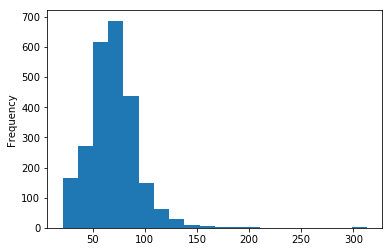

In [18]:
data_df['Lot Frontage'].plot.hist(bins=20)
plt.show()

Previous graph shows that we have some outliers in this columns, and most of the datapoints are centered on a value around 60.

The approach we can choose to handle null values in this column is to replace them by the mean value of the column, without the outliers and null values. See below the new histogram and the mean value calculated. This value will be used to replace null values in that column.

Mean value calculated with the reduced dataset: 68.46


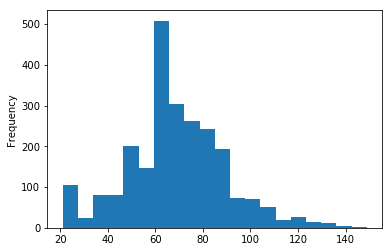

In [19]:
data_df['Lot Frontage'][np.logical_and(data_df['Lot Frontage'] < 150, data_df['Lot Frontage'] > 0)].plot.hist(bins=20)
mean_value = data_df['Lot Frontage'][np.logical_and(data_df['Lot Frontage'] < 150, data_df['Lot Frontage'] > 0)].mean()
print("Mean value calculated with the reduced dataset: {:.2f}".format(mean_value))


In [20]:
data_df['Lot Frontage'] = data_df['Lot Frontage'].fillna(int(mean_value))

print("Number of null value in dataframe:", data_df.isnull().sum().sum())
print("Dataframe size:", data_df.shape)
print("Good :-)")



Number of null value in dataframe: 1754
Dataframe size: (2930, 87)
Good :-)


Fine. Our dataset has now 0 null values. It's time now to perform feature encoding and feature engineering 

Before that, let's classify columns in four categories using the documentation provided with the dataset. Goal is to build 4 list of column names, one for each type: continuous, nominal, ordinal and discrete.

In [21]:
# Continuous variables
continuous_column = [
    '1st Flr SF', '2nd Flr SF', 'Lot Frontage Clean', 'Lot Area', 'Mas Vnr Area', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Total Bsmt SF',
    'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', '3Ssn Porch', 'Open Porch SF', 'Wood Deck SF', 'Pool Area', 'Screen Porch', 'Misc Val', 'Enclosed Porch',
]

# Nominal variables - no possible ordering
nominal_column = [
    'MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Exterior 1st',
    'Exterior 2nd', 'Roof Matl', 'Roof Style', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Sale Condition', 'Sale Type', 'Street',
]

# Ordinal variables - you can order the categories
ordinal_column =[
    'Lot Shape', 'Land Slope', 'Overall Cond', 'Overall Qual', 'Exter Cond', 'Exter Qual', 'Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1',
    'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Finish', 'Garage Cond', 'Garage Qual', 'Paved Drive',
]

# Discrete variables - categories are integer values
discrete_column = [
    'Year Built', 'Year Remod/Add', 'Mo Sold', 'Yr Sold', 'Full Bath', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces',
    'Garage Yr Blt', 'Garage Cars', 'Bedroom AbvGr', 'Kitchen AbvGr',
]

y_column = [
 'SalePrice',
]

# This trick should return an the columns we've one-hot encoded above, number of these should be 15
unclassified_columns = set(data_df.columns.values.tolist()) - set(continuous_column) - set(nominal_column) - set(ordinal_column) - set(discrete_column) - set(y_column)
print("Number of column not classified:",len(unclassified_columns))
print("Column names:",','.join(sorted(unclassified_columns)))

Number of column not classified: 14
Column names: Alley Exists,Alley Type_Grvl,Alley Type_Pave,Fence Exists,Fireplace Exists,Fireplace Quality,Lot Frontage,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Pool QC Exists,Utilities


## Feature encoding

### Ordinal columns

Let's consider first the ordinal columns, and convert them to numerical column for better model fitting, using our previous encodeOrdinalColumnToNumeric() function.

Looking at some of those columns, we must perform some more data cleaning before converting them.

#### Basement

Basement information are contained in 8 Bsmt* columns plus 'Total Bsmt SF'. 5 of them are ordinal:
* Bsmt Cond
* Bsmt Exposure
* Bsmt Qual
* BsmtFin Type 1
* BsmtFin Type 2

We will encode them as numerical column, which will remove null values, and build another column which states if the house has a basement. This new column will be based on the 'Total Bsml SF' column and will be 'one-hot' encoded.

Before that, I do a small control to ensure that Total Bsmt SF = Bsmt 1 SF + Bsmt 2 SF + Basmt Unfinished SF

In [22]:
temp_df = data_df[['Total Bsmt SF','Bsmt Unf SF','Bsmt Cond','Bsmt Exposure','Bsmt Qual','BsmtFin Type 1','BsmtFin Type 2','BsmtFin SF 1','BsmtFin SF 2']].copy()
temp_df['Sum'] = data_df['BsmtFin SF 1'] + data_df['BsmtFin SF 2'] + data_df['Bsmt Unf SF']
temp_df['Equal ?'] = temp_df['Sum'] == temp_df['Total Bsmt SF']
print(temp_df['Equal ?'].value_counts())
print("No False result, equality between cells about Square Feet is respected")

True     2929
False       1
Name: Equal ?, dtype: int64
No False result, equality between cells about Square Feet is respected


One more thing is the ordinal value 'Unf' in 'BsmtFin Type 1' and 'BsmFin Type 2'. This value does not evaluate the quality of the basement but the fact that it is not finished.

I will then create two new columns 'Bsmt Type 1 Exists' and 'Bsmt Type 2 Exists' with 1 or 0 value. Then, on the BsmtFin Type 1 & 2 column, I will replace 'Unf' values with 0.

In [23]:
# Create Basement Exists, Bsmt Type 1 & 2 Unf and one encode them
data_df['Bsmt Exists'] = np.where(data_df['Total Bsmt SF'] == 0, 0, 1)
data_df['Bsmt Type 1 Exists'] = np.where(data_df['BsmtFin Type 1'] == 'Unf', 0, 1)
data_df['Bsmt Type 2 Exists'] = np.where(data_df['BsmtFin Type 2'] == 'Unf', 0, 1)
ordinal_column.extend(['Bsmt Exists', 'Bsmt Type 1 Exists','Bsmt Type 2 Exists'])
# DO NOT FORGET TO REPLICATE THAT CHANGE IN test_df
test_df['Bsmt Exists'] = np.where(test_df['Total Bsmt SF'] == 0, 0, 1)
test_df['Bsmt Type 1 Exists'] = np.where(test_df['BsmtFin Type 1'] == 'Unf', 0, 1)
test_df['Bsmt Type 2 Exists'] = np.where(test_df['BsmtFin Type 2'] == 'Unf', 0, 1)


# Convert ordinal Bsmt columns to numerical
mapping = {
    'Bsmt Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Bsmt Cond': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Bsmt Exposure': { 'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1 },
    'BsmtFin Type 1': { 'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0 },
    'BsmtFin Type 2': { 'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0 },
}
for c in mapping:
    encodeOrdinalColumnToNumeric(data_df, column=c, mapping=mapping[c], replacena=0)


NameError: name 'encodeOrdinalColumnToNumeric' is not defined

#### Utilities

The 'Utilities' ordinal column is a bit special as all but three entries are identical. This let me think that this information is really not usefull to fit a model.

Instead of dropping this columns, I would prefer to drop the three lines that are different from the rest. This will avoid having outliers in our train dataset for house sale prices as these three houses do not have all the basic utilities. Furthermode, a look at the test dataset shows that we do have only houses in this 500 lines dataset with all the Utilities. Loosing information on how much incomplete utilities can modify the sale price is useless here.

In [ ]:
print("Existing values in 'Utilities' column of the test dataset is unique:")
print(test_df['Utilities'].value_counts())
print("We can drop the 'Utilities' and column from the train dataset and remove the three houses")

# Remove the three houses that do not have all the utilities
data_df = data_df[data_df['Utilities'] == 'AllPub']
addColumnToDropList(['Utilities'])



#### Garage

Garage is nearly the same as for Basement. Some of the houses do not have garage.

Best way shoulod be to create a new column 'Has Garage' and convert ordinal Garage columns to numerical values.



In [ ]:
# Create Garage Exists and one encode it (do not forget test_df)
data_df['Garage Exists'] = np.where(data_df['Garage Area'] == 0, 0, 1)
test_df['Garage Exists'] = np.where(test_df['Garage Area'] == 0, 0, 1)
# addColumnToOneHotEncoding(['Has Garage'])

# Convert ordinal Garage columns to numerical
mapping = {
    'Garage Finish': {'Fin': 3, 'RFn': 2, 'Unf': 1 },
    'Garage Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Garage Cond': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
}

for c in mapping:
    encodeOrdinalColumnToNumeric(data_df, column=c, mapping=mapping[c], replacena=0)

#### Remaining ordinal columns

The remaining ordinal columns are simply re-encoded using numerical values, except for 'Overall Cond' and 'Overall Qual' as those two columns are already ordinal ones with numeric values.


In [ ]:
mapping = {
    'Electrical': { 'SBrkr': 5, 'FuseA': 4,'FuseF': 3,'FuseP': 2, 'Mix': 1 },
    'Exter Cond': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Exter Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Functional': { 'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 0 },
    'Heating QC': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Kitchen Qual': { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 },
    'Land Slope': { 'Gtl': 3, 'Mod': 2, 'Sev': 1 },
    'Lot Shape': { 'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1 },
    'Paved Drive': { 'Y': 3, 'P': 2, 'N': 1 },
}

for c in mapping:
    encodeOrdinalColumnToNumeric(data_df, column=c, mapping=mapping[c], replacena=0)


#### Clean up

Now that all our ordinal column have been transformed and/or re-encoded, let's drop and one-hot encode the columns and check that our ordinal columns of our dataframe are all dtype = numeric

In [ ]:
dropAndEncode()

data_df[ordinal_column].dtypes


### Nominal columns

Regarding nominal columns, option is very simple. We must perform one-hot encoding on each to get numeric columns.

In [ ]:
addColumnToOneHotEncoding(nominal_column)
dropAndEncode()


### Discrete columns

* Find the houses solded as new one
* Find houses that have been remoded

In [ ]:
for c in sorted(discrete_column):
    print(c,":\t",sorted(data_df[c].unique()))

In [ ]:
for c in data_df.select_dtypes(np.number):
    c_mean = data_df[c].mean()
    c_std  = data_df[c].std()
    z_min  = (c_mean-data_df[c].min())/c_std
    z_max  = (data_df[c].max()-c_mean)/c_std
    outliers = ''
    if (z_min > 2 or z_max > 2):
        outliers = '(outliers)'
    #print("Column {:20s} mean:{:9.2f}\tstd:{:9.2f}\tz-min:{:9.2f}\tz-max:{:10.2f} {}".format(c, c_mean, c_std, z_min, z_max, outliers))
    

In [ ]:
data_df['Pool Area'].sort_values(ascending=False)
temp_df = data_df[data_df['Pool Area'] > 0]
plt.scatter(temp_df['Pool Area'], temp_df['SalePrice'])

In [ ]:
plt.figure(figsize=(15,10))
data_df[continuous_column].hist(figsize=(15,15))
plt.show()

## Feature engineering

## Model fitting

## Regularization

## Communicating the results

## Compute predictions

## Evaluate your predictions